# CNN 2D IoT Classification Model

In [1]:
from __future__ import print_function
import h5py
import numpy as np
import matplotlib.pyplot as plt
from sklearn.utils import class_weight
from sklearn.metrics import classification_report
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Input, Concatenate, Reshape
from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
from keras.utils import plot_model
from keras.models import Model
from keras.optimizers import adadelta as ada
from PIL import Image
import matplotlib.pyplot as plt
import pandas as pd
import copy
import pydot

from hyperopt import Trials, STATUS_OK, tpe
from hyperas import optim
from hyperas.distributions import choice, uniform

%matplotlib inline

Using TensorFlow backend.


## Open and Read Data

In [2]:
def data():
    hdf5_path = 'dataset.hdf5'
    subtract_mean = True
    hdf5_file = h5py.File(hdf5_path, "r")
    if subtract_mean:
        mm = hdf5_file["train_mean"][0, ...]
        mm = mm[np.newaxis, ...]
    data_num = hdf5_file["train_flow"].shape[0]
    

    
    num_classes = 2
    epochs = 30

    flow_rows, flow_cols = 298, 17

    

    x_train = hdf5_file["train_flow"][:,...]
    if subtract_mean:
        x_train -= mm

    y_train = hdf5_file["train_labels"][:, ...]

    hdf5_file.close()
    
    hdf5_path = 'dataset-IoT.hdf5'
    hdf5_file = h5py.File(hdf5_path, "r")

    x_test = hdf5_file["IoT_flow"][:,...]
    if subtract_mean:
        x_test -= mm

    y_test = hdf5_file["labels"][:, ...]

    hdf5_file.close()





    class_weights = class_weight.compute_class_weight('balanced',
                                                 np.unique(y_train),
                                                 y_train)
    d_class_weights = dict(enumerate(class_weights))

    input_shape = (x_train.shape[1], x_train.shape[2], x_train.shape[3])


    y_train = keras.utils.to_categorical(y_train, num_classes)
    y_test = keras.utils.to_categorical(y_test, num_classes)
    return x_train, y_train, x_test, y_test

## Build Model

In [3]:
def create_model(x_train, y_train, x_test, y_test):
    batch_size = {{choice([128,256])}}
    epochs = 30
    filters={{choice([32,64,128])}}
    kernel_size={{choice([(2,2),(3,3)])}}
    activations={{choice(['relu', 'sigmoid', 'tanh'])}}
    pool_size={{choice([(2,2),(3,3)])}}
    dropout = {{uniform(0.1, 0.3)}}
    optimizers={{choice([keras.optimizers.Adadelta(lr=0.001),keras.optimizers.RMSprop(lr=0.001),keras.optimizers.Adam(lr=0.001)])}}
    layers = {{choice([1,2,3,4])}}
    model = Sequential()
    model.add(Conv2D(filters, kernel_size=kernel_size,activation=activations, input_shape=input_shape,padding = "same"))
    for i in range(layers-1):
        model.add(Conv2D(filters,kernel_size=kernel_size, activation=activations, padding = "valid"))
        
    model.add(MaxPooling2D(pool_size=(pool_size)))
    model.add(Flatten())
    model.add(Dropout(dropout))
    model.add(Dense(64, activation='relu'))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(dropout))
    model.add(Dense(num_classes, activation='softmax'))
    model.summary()
    model.compile(loss='binary_crossentropy', optimizer=optimizers, metrics=['accuracy'])
    model.fit(x_train,y_train, batch_size=batch_size, epochs=epochs, verbose=0, validation_split=0.2, class_weight=class_weights, shuffle=True)
    score = model.evaluate(x_test, y_test, verbose=0)
    loss = score[0]
    return {'loss': loss, 'status': STATUS_OK, 'model': model} 

## Run Model

In [4]:
x_train, y_train, x_test, y_test = data()
best_run, best_model = optim.minimize(model=create_model, data=data, algo=tpe.suggest, max_evals=75, trials=Trials(), eval_space=True, notebook_name='cnn2D')

print("Evalutation of best performing model:")
print(best_model.evaluate(x_test, y_test))
print("Best performing model chosen hyper-parameters:")
print(best_run)

>>> Imports:
#coding=utf-8

from __future__ import print_function

try:
    import h5py
except:
    pass

try:
    import numpy as np
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    from sklearn.utils import class_weight
except:
    pass

try:
    from sklearn.metrics import classification_report
except:
    pass

try:
    import keras
except:
    pass

try:
    from keras.models import Sequential
except:
    pass

try:
    from keras.layers import Dense, Dropout, Flatten, Input, Concatenate, Reshape
except:
    pass

try:
    from keras.layers import Conv2D, MaxPooling2D, AveragePooling2D
except:
    pass

try:
    from keras.utils import plot_model
except:
    pass

try:
    from keras.models import Model
except:
    pass

try:
    from keras.optimizers import adadelta as ada
except:
    pass

try:
    from PIL import Image
except:
    pass

try:
    import matplotlib.pyplot as plt
except:
    pass

try:
    import pandas as pd
except:
    pass



## Model Analysis
#### Classification Report
#### Confusion Matrix
#### Area Under Reciever Operating Characteristic Curve

              precision    recall  f1-score   support

           0       0.90      0.98      0.94     34974
           1       0.81      0.50      0.62      7193

   micro avg       0.89      0.89      0.89     42167
   macro avg       0.86      0.74      0.78     42167
weighted avg       0.89      0.89      0.88     42167

[[34122   852]
 [ 3585  3608]]
0.9197113327402691


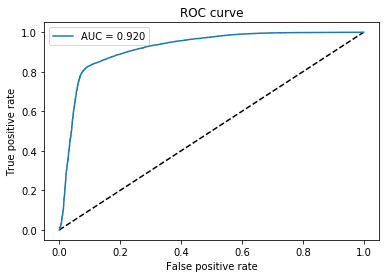

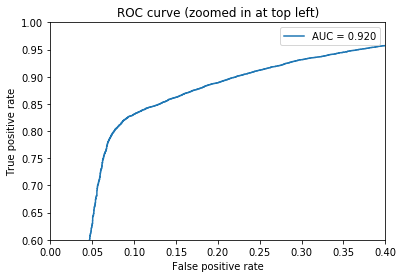

In [5]:
y_pred = best_model.predict(x_test)
yy_test = [np.argmax(i) for i in y_test]

yy_pred = [np.argmax(i) for i in y_pred]

print(classification_report(yy_test, yy_pred))     
  
new = np.vstack([yy_test,yy_pred])

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve
from sklearn.metrics import auc

print(confusion_matrix(yy_test, yy_pred))



y_pred_keras = best_model.predict(x_test).ravel()
fpr_keras, tpr_keras, thresholds_keras = roc_curve(yy_test, y_pred[:,0],pos_label=0)
auc_keras = auc(fpr_keras, tpr_keras)
print(auc_keras)

f1 = plt.figure()
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()
f1.savefig("ROC-curve-cnn2D.pdf", bbox_inches='tight')

f2 = plt.figure()
plt.xlim(0, 0.4)
plt.ylim(0.6, 1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='AUC = {:.3f}'.format(auc_keras))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve (zoomed in at top left)')
plt.legend(loc='best')
plt.show()
f2.savefig("ROC-curve-zoomed-cnn2D.pdf", bbox_inches='tight')




In [6]:
best_model.save('cnn2D.h5')

## Save Model Analysis Data

In [7]:
d = {'False Positive Rate': fpr_keras, 'True Positive Rate': tpr_keras , 'Thresholds': thresholds_keras}

In [8]:
roc_CNN2D = pd.DataFrame(data=d)

In [9]:
roc_CNN2D.to_csv(path_or_buf ='rocCNN2D.csv', index=False)

In [10]:
conf = confusion_matrix(yy_test, yy_pred)

In [11]:
conf2D=pd.DataFrame(data=conf)

In [12]:
conf2D.to_csv(path_or_buf='ConfusionCNN2D.csv',index=False)